# Species Distribution Modelling

In this notebook, a Species Distribution Modelling (SDM) experiment based on climatic and aerosol variables is performed with data about the Amazon Basin region collected by the GoAmazon 2014/15 project.  

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, average_precision_score, precision_score, accuracy_score, classification_report, roc_auc_score

In [2]:
def data_prep(df, list_variables, species):
    """
    Select features and target variables, scale and split into train and test datasets. 
    Balance the dataset with SMOTE technique.
    
    """
    
    # Select features
    X = df[list_variables]

    # Target target
    y = df[[species]]

    # Data scalling
    scaler = MinMaxScaler()
    norm_X = scaler.fit_transform(X)
    
    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(norm_X,y, random_state = random_seed, test_size = 0.3)

    # Class balanced
    sm = SMOTE(random_state = random_seed, sampling_strategy = 0.3)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    return X_test, y_test, X_train, y_train


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Plot the confusion matrix to evaluate the performance of the classifier
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def tune_hyperparameters(X_train,y_train,grid):
    """
    Tune the hyperparameters for the classifier
    """

    # Define the folds to perform the cross validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_seed)
    model = LogisticRegression(random_state=random_seed)
    
    # GridSearchCV to tune the hyperparameters
    space = {'C':grid}
    search = GridSearchCV(model, space, cv=cv)
    result = search.fit(X_train, np.ravel(y_train))
    print('Best accuracy: {}'.format(round(result.best_score_,2))); print('Best hyperparameter: {}'.format(result.best_params_))
    
    return result.best_params_['C']
    
    
def train_classifier(X_train, y_train, X_test, y_test, species, C):
    """
    Train the classifier and evaluate its performance
    
    """
    
    # Define and train the model    
    clf = LogisticRegression(random_state=random_seed, C=C)
    clf.fit(X_train, y_train[species].array)
    
    # Plot the confusion matrix for the train dataset
    y_pre = clf.predict(X_train)
    cnf_matrix = confusion_matrix(y_train[species].array, y_pre)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix - Train Dataset')
    plt.show()
    
    # Desempenho no Train Dataset
    print('Performance in the Train Dataset')
    print(classification_report(y_train[species].array, y_pre))
    
    # ROC_AUC in the Train Dataset
    logit_roc_auc = roc_auc_score(y_train[species].array, clf.predict_proba(X_train)[:,1])
    fpr, tpr, thresholds = roc_curve(y_train[species].array, clf.predict_proba(X_train)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Train Set')
    plt.legend(loc="lower right")
    plt.show()
    

    # Plot the confusion matrix for the test dataset
    y_pre = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test[species].array, y_pre)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion Matrix - Test Dataset')
    plt.show()
    
    # Performance in the Test Dataset
    print('Performance in the Test Dataset')
    print(classification_report(y_test[species].array, y_pre))
    
    # ROC_AUC in the Test Dataset
    logit_roc_auc = roc_auc_score(y_test[species].array, clf.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test[species].array, clf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Test Dataset')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf


def plot_species_dist_map(df, list_variables, species):
    
    # Select columns
    X = df[list_variables]
    
    # Data scalling
    scaler = MinMaxScaler()
    norm_X = scaler.fit_transform(X)

    # Predict the probability
    y_proba = clf.predict_proba(norm_X)[:,1]
    df.loc[:,'prediction'] = y_proba
    
    # Filter for real occurrences
    df_1 = df[df[species]==1]
    
    # Pivot dataset
    pred_final = df[['latitude','longitude','prediction']]
    df_sort = pred_final.sort_values(by=['latitude', 'longitude'], ascending=True).reset_index(drop=True)
    df_sort['latitude'] = df_sort['latitude'].apply(lambda x: float(x))
    df_sort['longitude'] = df_sort['longitude'].apply(lambda x: float(x))
    df_pivoted = df_sort.drop_duplicates(['latitude','longitude']).pivot(index='latitude', columns='longitude', values='prediction')

    # Plot the species distribution map
    xi = list(df_pivoted.index)
    yi = list(df_pivoted.columns)

    levels = np.linspace(0.0, 1.0, 6)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.contourf(yi,xi,df_pivoted, levels=levels)
    plt.scatter(df_1['longitude'],df_1['latitude'], marker="^",color='black')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Latitude (°)')
    plt.title('Potential Distribution Map - {}'.format(species))
    plt.colorbar()
    plt.show()

In [3]:
# Read files
season = 'dry'
df = pd.read_csv('Bioclimatic_dataset_{}.csv'.format(season))
df.columns

C:\Users\agnei\AppData\Local\Temp\ipykernel_21444\483610866.py:3: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Bioclimatic_dataset_{}.csv'.format(season))


Index(['latitude', 'longitude', 'co(ppm)', 'o3(ppb)', 'nox(ppb)', 'CPC3010',
       'Acetonitrile(ppb)', 'Isoprene(ppb)', 'latitude_', 'longitude_',
       'species', 'key', 'date', 'species_Ammodramus aurifrons',
       'species_Aratinga leucophthalma', 'species_Ardea alba',
       'species_Brotogeris sanctithomae', 'species_Brotogeris versicolurus',
       'species_Busarellus nigricollis', 'species_Butorides striata',
       'species_Cacicus cela', 'species_Caiman crocodilus',
       'species_Cathartes aura', 'species_Chaetura brachyura',
       'species_Chelidoptera tenebrosa', 'species_Columbina passerina',
       'species_Columbina talpacoti', 'species_Coragyps atratus',
       'species_Crotophaga ani', 'species_Crotophaga major',
       'species_Dendrocygna autumnalis', 'species_Egretta thula',
       'species_Jacana jacana', 'species_Legatus leucophaius',
       'species_Megaceryle torquata', 'species_Milvago chimachima',
       'species_Myiozetetes cayanensis', 'species_Paleosu

Best accuracy: 0.78
Best hyperparameter: {'C': 5}


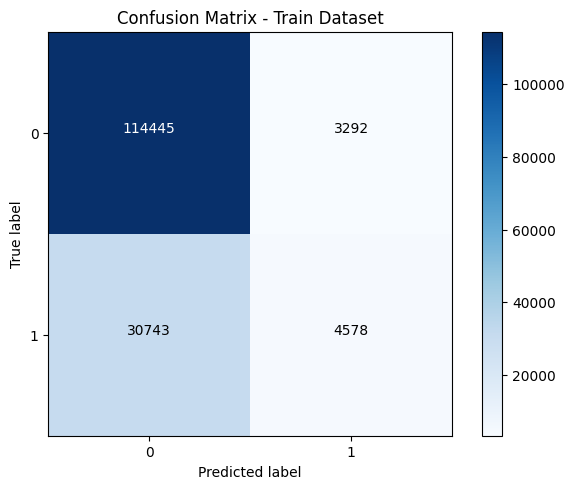

Performance in the Train Dataset
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87    117737
         1.0       0.58      0.13      0.21     35321

    accuracy                           0.78    153058
   macro avg       0.68      0.55      0.54    153058
weighted avg       0.74      0.78      0.72    153058



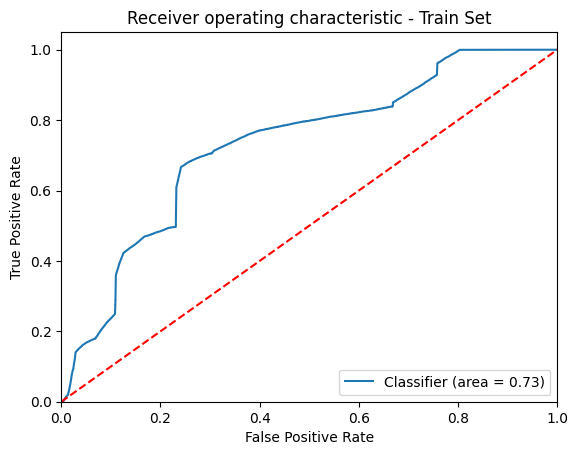

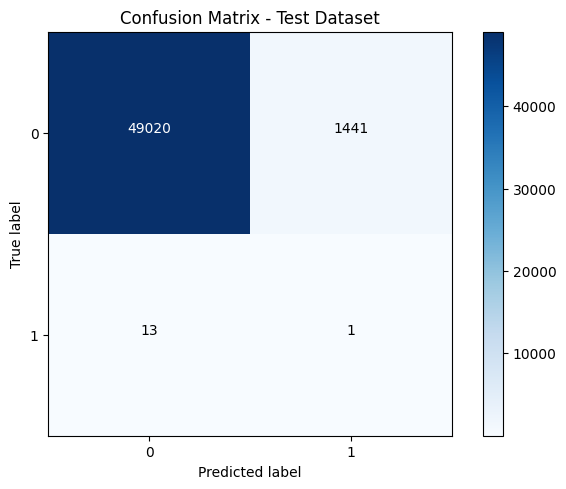

Performance in the Test Dataset
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     50461
         1.0       0.00      0.07      0.00        14

    accuracy                           0.97     50475
   macro avg       0.50      0.52      0.49     50475
weighted avg       1.00      0.97      0.99     50475



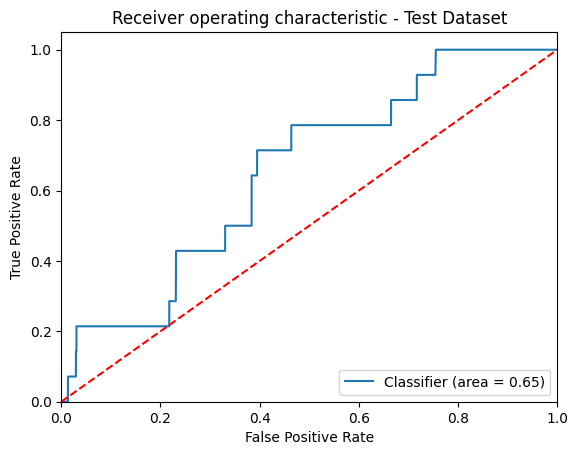

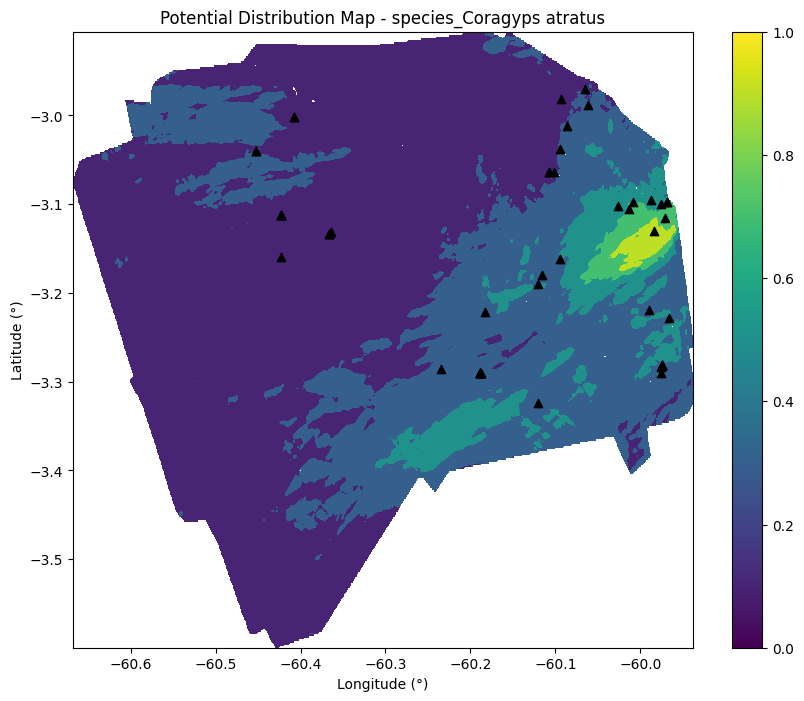

In [4]:
list_variables = ['co(ppm)', 'o3(ppb)', 'nox(ppb)', 'CPC3010', 'Acetonitrile(ppb)', 'Isoprene(ppb)']
species = 'species_Coragyps atratus'
random_seed = 42
grid = [0.001,0.005,0.01,0.05,0.1,1,2,3,4,5]

X_test, y_test, X_train, y_train = data_prep(df, list_variables, species)
C = tune_hyperparameters(X_train,y_train,grid)
clf = train_classifier(X_train, y_train, X_test, y_test,species,C)
plot_species_dist_map(df, list_variables, species)